# Deep Learning - LSTM
**Executive Master Statistique & Big Data**   
Elodie Zanella & Oussama Berguiga  
*Août 2018*

Nous avons choisi de travailler sur un jeu de données libre d'accès (issu de Data Market) décrivant le nombre moyen mensuel de tâches solaires observées depuis 230 ans (de 1749 à 1983) à Zurich.  
Il s'agit d'une série temporelle sur laquelle nous appliquerons des LSTM pour prédire le nombre moyen de tâches solaires pour un un instant t (qui correspond à un certain mois), basé sur une fenêtre temporelle plus ou moins large du passé.   

*Source : https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983*

In [38]:
import pandas as pd
import numpy as np

import math
import time

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 0. Chargement et préparation des données

In [39]:
data_train=pd.read_csv('monthly-sunspot-number-zurich-17.csv',usecols=[1])

In [40]:
data_train.head()

,"Monthly sunspot number, Zurich, 1749-1983"
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


In [41]:
print(list(data_train))

['Monthly sunspot number, Zurich, 1749-1983']


In [42]:
data_train=data_train[data_train['Monthly sunspot number, Zurich, 1749-1983']!=' Zurich']
print(data_train['Monthly sunspot number, Zurich, 1749-1983'].unique())

['58.0' '62.6' '70.0' ... '106.1' '118.8' '127.0']


In [43]:
data_train.dtypes

Monthly sunspot number, Zurich, 1749-1983    object
dtype: object

In [44]:
data_train['Monthly sunspot number, Zurich, 1749-1983']=data_train['Monthly sunspot number, Zurich, 1749-1983'].astype('float')

In [45]:
data_train.shape

(2820, 1)

In [46]:
data_train.describe()

,"Monthly sunspot number, Zurich, 1749-1983"
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


2 820 observations, de 0 à 253,8 avec une moyenne à 51,3 tâches solaires observées dans le mois.

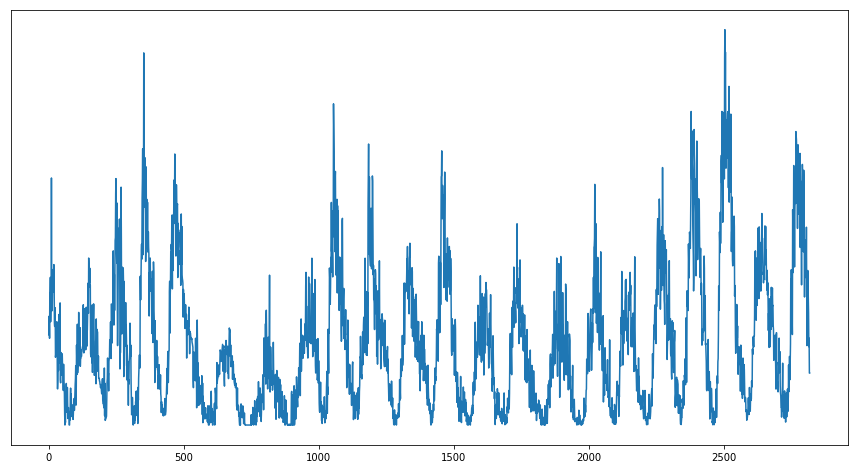

In [47]:
plt.figure(figsize=(15,8))
plt.yticks([])
plt.plot(data_train)

In [48]:
data_train=data_train.dropna()

Normalisation des données via MinMaxScaler

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset=data_train.values
dataset = scaler.fit_transform(dataset)

In [50]:
dataset

array([[0.2285264 ],
       [0.24665091],
       [0.27580772],
       ...,
       [0.21985816],
       [0.13120567],
       [0.13159968]])

## 1. Modélisation

Création des jeux d'apprentissage et de test

In [51]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1889 931


Création des séquences : a partir des données t-look_back, t-look_back+1, t-look_back+2 ..., t-1 on predit la valeur du nombre de tâches solaires à l'instant t

In [52]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Création des RNN

In [53]:
def lstm(look_back_list,batch_size_list,verbose=0,nombre_couches=1):

    best_Test_Score=100
    best_Train_Score=100
    best_look_back=0
    best_batch_size=0
    

   
    for look_back in look_back_list:
        for batch_size in batch_size_list:
            
    
    
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)

            # transformation de l'input sous la forme [taille d'échantillon, pas temporel, quantite de features]
            trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
            testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))




             # creation du LSTM
                
            if nombre_couches==1:
            
               
                model = Sequential()
                model.add(LSTM(100, input_shape=(1, look_back)))
                model.add(Dropout(0.2))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')


        
            elif nombre_couches==2:
                
                
                
                
                model = Sequential()


              


                model.add(LSTM( input_dim=look_back, output_dim=50,return_sequences=True))
                model.add(Dropout(0.2))

                model.add(LSTM(100,return_sequences=False))
                model.add(Dropout(0.2))




                model.add(Dense(output_dim=1))
                model.add(Activation('linear'))
                model.compile(loss='mean_squared_error', optimizer='rmsprop')
                
                
                
                


            # fit du réseau
            history = model.fit(trainX, trainY, epochs=20, batch_size=batch_size, verbose=verbose, shuffle=False)

            # predictions

            trainPredict = model.predict(trainX, batch_size=batch_size)
            testPredict = model.predict(testX, batch_size=batch_size)
            # inverse MinMax des predictions
            trainPredict = scaler.inverse_transform(trainPredict)
            trainY = scaler.inverse_transform([trainY])
            testPredict = scaler.inverse_transform(testPredict)
            testY = scaler.inverse_transform([testY])
           
        
             # calcul de la root mean squared error


            trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

            testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

            if testScore<best_Test_Score:

                best_Test_Score=testScore
                best_Train_Score=trainScore
                best_look_back=look_back
                best_batch_size=batch_size


    print('Best Look Back: %d ' % (best_look_back))
        
    print('Best Batch Size : %d ' % (best_batch_size))
       
    print('Best Train Score: %.2f RMSE' % (best_Train_Score))
    
    print('Best Test Score: %.2f RMSE' % (best_Test_Score))




In [54]:
look_back_list=[1,2,3,4,5,10]
batch_size_list=[20,50,100]

Un premier essai avec une couche

In [55]:
lstm(look_back_list,batch_size_list,verbose=0,nombre_couches=1)

Best Look Back: 10 
Best Batch Size : 50 
Best Train Score: 15.02 RMSE
Best Test Score: 17.46 RMSE


Un second essai avec deux couches

In [56]:
lstm(look_back_list,batch_size_list,verbose=0,nombre_couches=2)

C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 2), units=50)`
C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 3), units=50)`
C:\Users\oussa\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Update your `LSTM

Best Look Back: 4 
Best Batch Size : 100 
Best Train Score: 15.06 RMSE
Best Test Score: 17.46 RMSE


On remarque que les deux modeles (avec une ou  couches) donnent des résultats très proches en terme de RMSE sur jeu de test. Dans la suite on retient le réseau à une couche

In [57]:
look_back=10
batch_size=50
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# transformation de l'input pour etre de la forme [taille de l'echantillon, pas de temps, quanite de features]
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))



            
# creation and fit du meilleur modele
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



history = model.fit(trainX, trainY, epochs=30, batch_size=batch_size, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 1878 samples, validate on 920 samples
Epoch 1/30
 - 20s - loss: 0.0146 - val_loss: 0.0080
Epoch 2/30
 - 1s - loss: 0.0056 - val_loss: 0.0072
Epoch 3/30
 - 1s - loss: 0.0049 - val_loss: 0.0066
Epoch 4/30
 - 1s - loss: 0.0046 - val_loss: 0.0063
Epoch 5/30
 - 1s - loss: 0.0045 - val_loss: 0.0061
Epoch 6/30
 - 1s - loss: 0.0044 - val_loss: 0.0059
Epoch 7/30
 - 1s - loss: 0.0042 - val_loss: 0.0057
Epoch 8/30
 - 1s - loss: 0.0043 - val_loss: 0.0055
Epoch 9/30
 - 1s - loss: 0.0042 - val_loss: 0.0054
Epoch 10/30
 - 1s - loss: 0.0040 - val_loss: 0.0053
Epoch 11/30
 - 1s - loss: 0.0039 - val_loss: 0.0052
Epoch 12/30
 - 1s - loss: 0.0039 - val_loss: 0.0051
Epoch 13/30
 - 1s - loss: 0.0039 - val_loss: 0.0050
Epoch 14/30
 - 1s - loss: 0.0037 - val_loss: 0.0050
Epoch 15/30
 - 1s - loss: 0.0038 - val_loss: 0.0049
Epoch 16/30
 - 1s - loss: 0.0038 - val_loss: 0.0049
Epoch 17/30
 - 1s - loss: 0.0038 - val_loss: 0.0048
Epoch 18/30
 - 1s - loss: 0.0037 - val_loss: 0.0048
Epoch 19/30
 - 1s - loss:

Visualisation de l'erreur pour vérifier la convergence de l'algorithme et donc la pertinence du nombre d'epochs choisi

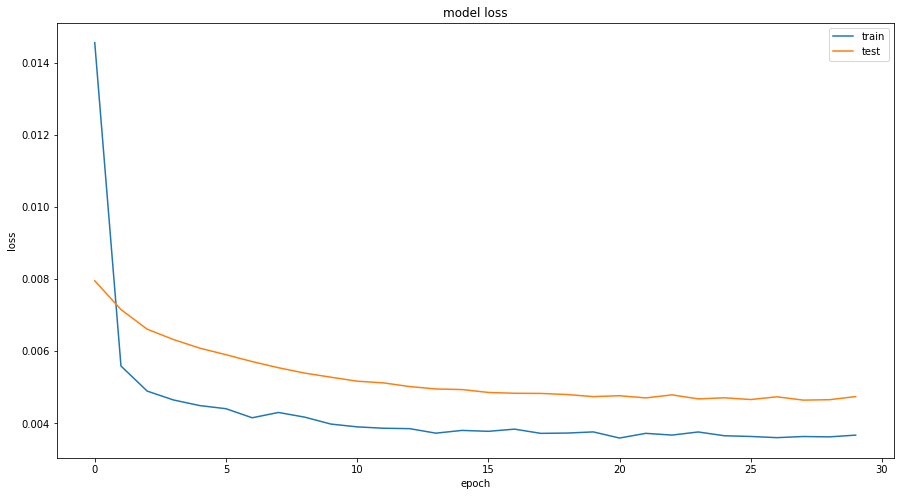

In [58]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 2. Predictions

A partir des données t-look_back, t-look_back+1, t-look_back+2 ..., t-1 on predit la valeur du nombre de tâches solaires à l'instant t. Puis on compare pour tout t supérieur a look_back les valeurs prédites aux valeurs réelles, et ce à la fois pour le train et le test

In [59]:
# predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)


# transformation inverse MinMax des predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# calcul de la root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.94 RMSE
Test Score: 17.47 RMSE


On arrive a une RMSE d'environ 17 sur le jeu de test sachant que le nombre de tâches varie entre 0 et 250, une moyenne de 51
ce qui peut sembler un score de mauvaise qualite

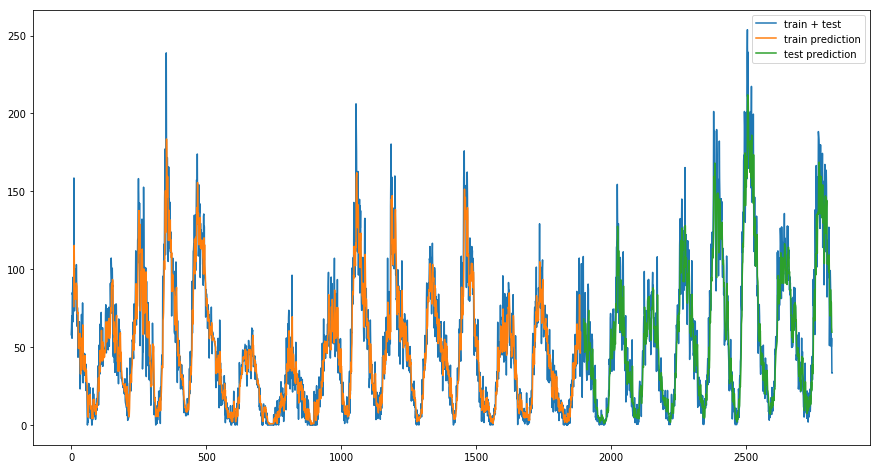

In [60]:
# decalage de la prediction du train pour comparer au train reel a partir du t=look_up
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# decalage de la prediction test pour comparer au test reel a partir de t=look_up du jeu de test
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# plot du train + test initial et des predictions respectives
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['train + test','train prediction', 'test prediction'], loc='upper right')

plt.show()



Cependant graphiquement les prédictions sur train et test semblent globalement satisfaisantes, sauf pour les valeurs extrêmes.